In [ ]:
!pip install transformers datasets
!pip install torch
!pip install matplotlib
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = load_dataset("glue", "sst2")
small_train_data, small_new_val_data = dataset['train'].shuffle(seed=42).select(range(3000)).train_test_split(test_size=0.1, seed=42).values()
small_val_dataset = dataset['validation'].shuffle(seed=42).select(range(600))



In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

for dataset in (small_train_data, small_new_val_data, small_val_dataset):
    dataset.map(tokenize_function, batched=True).set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    logging_dir='./logs',
    logging_steps=25,
    save_steps=50,
    save_total_limit=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    resume_from_checkpoint=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_data,
    eval_dataset=small_new_val_data,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
25,0.700300,0.693236,0.473333
50,0.690500,0.689794,0.530000
75,0.681900,0.685295,0.530000
100,0.667200,0.589642,0.603333
125,0.481800,0.320339,0.890000
150,0.401500,0.318493,0.890000
175,0.316600,0.314991,0.903333
200,0.324400,0.315880,0.903333
225,0.424400,0.332479,0.866667
250,0.397500,0.255744,0.916667


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled
early stopping required metr

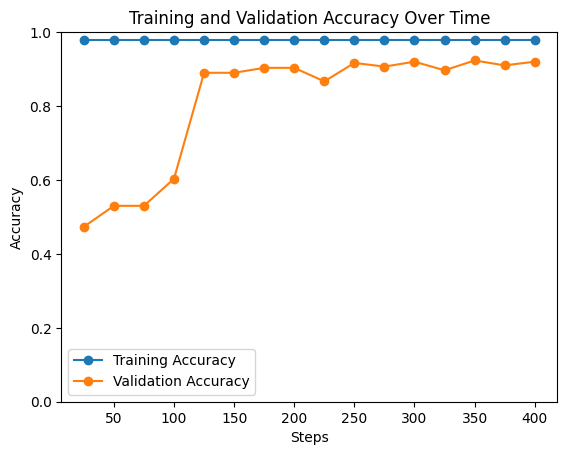

In [4]:
train_steps, validation_accuracy = zip(*[(log['step'], log['eval_accuracy']) for log in trainer.state.log_history if 'eval_accuracy' in log])
training_accuracy = [
    trainer.evaluate(eval_dataset=small_train_data.select(range(100)), metric_key_prefix="train")['train_accuracy']
    for _ in train_steps
]


plt.plot(train_steps, training_accuracy, label="Training Accuracy", marker='o')
plt.plot(train_steps, validation_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Training and Validation Accuracy Over Time")
plt.legend()
plt.show()

In [5]:
print(f"Test Accuracy: {trainer.evaluate(eval_dataset=small_val_dataset)['eval_accuracy']}")

Test Accuracy: 0.91
